## <u>2. Datenaufbereitung Installment Payments

In diesem Dokument werden für die Untersuchung unwichtige Variablen aus dem IP-Datensatz gelöscht und wichtige gruppiert. Im Gegensatz zu den Application-Daten liegt in dem IP-Datensatz eine N:M-Beziehung vor, da ein Kreditnehmer in der Vergangenheit mehrere Kredite gehabt haben kann und diese monatliche Kreditdaten beinhalten. Dies erfordert die Gruppierung der historischen Daten. Für die Bestimmung der Kreditwürdigkeit werden nur Daten historische Kontodaten benutzt, die maximal ein halbes Jahr in der Vergangenheit liegen. Zur Vergleichbarkeit der Zahlungshöhen im Zeitverlauf werden diese normalisiert.

*Vorgehensweise kategorische Variablen:*
- Gruppierung der Variablen
- Normalisierung der Variablen

## Initialisierung

In [1]:
from pathlib import Path
from scipy import stats

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

np.set_printoptions(suppress=True)

pd.options.display.max_columns = None
pd.options.display.max_rows = None
pd.options.display.max_colwidth = None

from sklearn.linear_model import LogisticRegression

from IPython.display import display, Markdown

In [2]:
path1 = Path(r"A:\Workspace\Python\Masterarbeit\Kaggle Home Credit Datensatz")
path2 = Path(r"C:\Users\rober\Documents\Workspace\Python\Masterarbeit\Kaggle Home Credit Datensatz")

if path1.is_dir():
    DATASET_DIR = path1
else:
    DATASET_DIR = path2

In [3]:
ip = pd.read_csv(DATASET_DIR / "installments_payments.csv")
description = pd.read_csv(DATASET_DIR / "HomeCredit_columns_description.csv", encoding="latin", index_col=0)

In [4]:
des = description.loc[description['Table']=="installments_payments.csv", "Row":"Special"]

In [5]:
des

,Row,Description,Special
214,SK_ID_PREV,"ID of previous credit in Home credit related to loan in our sample. (One loan in our sample can have 0,1,2 or more previous loans in Home Credit)",hashed
215,SK_ID_CURR,ID of loan in our sample,hashed
216,NUM_INSTALMENT_VERSION,Version of installment calendar (0 is for credit card) of previous credit. Change of installment version from month to month signifies that some parameter of payment calendar has changed,NaN
217,NUM_INSTALMENT_NUMBER,On which installment we observe payment,NaN
218,DAYS_INSTALMENT,When the installment of previous credit was supposed to be paid (relative to application date of current loan),time only relative to the application
219,DAYS_ENTRY_PAYMENT,When was the installments of previous credit paid actually (relative to application date of current loan),time only relative to the application
220,AMT_INSTALMENT,What was the prescribed installment amount of previous credit on this installment,NaN
221,AMT_PAYMENT,What the client actually paid on previous credit on this installment,NaN


In [6]:
ip[ip["SK_ID_PREV"] == 1682318].sort_values("NUM_INSTALMENT_NUMBER")

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
588168,1682318,161674,1.0,1,-270.0,-299.0,7374.51,7374.51
66454,1682318,161674,1.0,2,-240.0,-243.0,7374.51,7374.51
1865014,1682318,161674,1.0,3,-210.0,-215.0,7374.51,7374.51
1842575,1682318,161674,1.0,4,-180.0,-180.0,7374.51,7374.51
3669471,1682318,161674,1.0,5,-150.0,-152.0,7374.51,7374.51
2891187,1682318,161674,1.0,6,-120.0,-144.0,7374.51,7374.51
1844388,1682318,161674,1.0,7,-90.0,-92.0,7374.51,7374.51
2152079,1682318,161674,2.0,8,-60.0,-62.0,21070.62,21070.62


# Informationen
* Zahlungshistorie der letzen 0-6 Monate
* Differenz der Zahlungstage (viele Tage vor bzw. nach der Zahlungsdeadline hat ein Kreditnehmer tatsächlich überwiesen)
* Differenz der Zahlungshöhe (hat ein Kreditnehmer zu viel bzw. zu wenig Überwiesen)

In [7]:
df = ip.copy()

In [8]:
df["DAYS_DIFF"] = df["DAYS_ENTRY_PAYMENT"] - df["DAYS_INSTALMENT"]
df["AMT_DIFF"] = df["AMT_INSTALMENT"] - df["AMT_PAYMENT"]

In [9]:
df = df[df["DAYS_INSTALMENT"] > -180] # es werden nur Daten aus dem letzten halben Jahr betrachtet

In [10]:
T1 = df[ (0 > df["DAYS_INSTALMENT"]) & (df["DAYS_INSTALMENT"] >= -30)][["SK_ID_PREV", "AMT_PAYMENT", "DAYS_DIFF", "AMT_DIFF"]]
T2 = df[ (-30 > df["DAYS_INSTALMENT"]) & (df["DAYS_INSTALMENT"] >= -60)][["SK_ID_PREV", "AMT_PAYMENT", "DAYS_DIFF", "AMT_DIFF"]]
T3 = df[ (-60 > df["DAYS_INSTALMENT"]) & (df["DAYS_INSTALMENT"] >= -90)][["SK_ID_PREV", "AMT_PAYMENT", "DAYS_DIFF", "AMT_DIFF"]]
T4 = df[ (-90 > df["DAYS_INSTALMENT"]) & (df["DAYS_INSTALMENT"] >= -120)][["SK_ID_PREV", "AMT_PAYMENT", "DAYS_DIFF", "AMT_DIFF"]]
T5 = df[ (-120 > df["DAYS_INSTALMENT"]) & (df["DAYS_INSTALMENT"] >= -150)][["SK_ID_PREV", "AMT_PAYMENT", "DAYS_DIFF", "AMT_DIFF"]]
T6 = df[ (-150 > df["DAYS_INSTALMENT"]) & (df["DAYS_INSTALMENT"] >= -180)][["SK_ID_PREV", "AMT_PAYMENT", "DAYS_DIFF", "AMT_DIFF"]]

In [11]:
T1 = T1.groupby(by="SK_ID_PREV").sum()
T1.columns = ["PAYMENT_30", "DAYS_DIFF_30", "AMT_DIFF_30"]

T2 = T2.groupby(by="SK_ID_PREV").sum()
T2.columns = ["PAYMENT_60", "DAYS_DIFF_60", "AMT_DIFF_60"]

T3 = T3.groupby(by="SK_ID_PREV").sum()
T3.columns = ["PAYMENT_90", "DAYS_DIFF_90", "AMT_DIFF_90"]

T4 = T4.groupby(by="SK_ID_PREV").sum()
T4.columns = ["PAYMENT_120", "DAYS_DIFF_120", "AMT_DIFF_120"]

T5 = T5.groupby(by="SK_ID_PREV").sum()
T5.columns = ["PAYMENT_150", "DAYS_DIFF_150", "AMT_DIFF_150"]

T6 = T6.groupby(by="SK_ID_PREV").sum()
T6.columns = ["PAYMENT_180", "DAYS_DIFF_180", "AMT_DIFF_180"]

In [12]:
result = pd.DataFrame(index=df.SK_ID_PREV.unique())
result.index.name = "SK_ID_PREV"

In [13]:
result = pd.merge(result, T1, how="left", left_index=True, right_index=True)
result = pd.merge(result, T2, how="left", left_index=True, right_index=True)
result = pd.merge(result, T3, how="left", left_index=True, right_index=True)
result = pd.merge(result, T4, how="left", left_index=True, right_index=True)
result = pd.merge(result, T5, how="left", left_index=True, right_index=True)
result = pd.merge(result, T6, how="left", left_index=True, right_index=True)

In [14]:
result = result.fillna(0)

In [15]:
df = result

In [16]:
df.head()

,PAYMENT_30,DAYS_DIFF_30,AMT_DIFF_30,PAYMENT_60,DAYS_DIFF_60,AMT_DIFF_60,PAYMENT_90,DAYS_DIFF_90,AMT_DIFF_90,PAYMENT_120,DAYS_DIFF_120,AMT_DIFF_120,PAYMENT_150,DAYS_DIFF_150,AMT_DIFF_150,PAYMENT_180,DAYS_DIFF_180,AMT_DIFF_180
SK_ID_PREV,,,,,,,,,,,,,,,,,,
2085231,8393.175,-7.0,0.0,631.035,23.0,0.0,25425.000,0.0,0.0,0.000,0.0,0.0,0.000,0.0,0.0,0.000,0.0,0.0
2260765,13494.915,0.0,0.0,13494.915,-3.0,0.0,13494.915,-2.0,0.0,13494.915,0.0,0.0,13494.915,0.0,0.0,13494.915,-1.0,0.0
1184783,0.000,0.0,0.0,503.460,0.0,0.0,503.460,0.0,0.0,503.460,0.0,0.0,503.460,0.0,0.0,503.460,0.0,0.0
1003606,110.655,0.0,0.0,110.655,0.0,0.0,110.655,0.0,0.0,110.655,0.0,0.0,110.655,0.0,0.0,110.655,0.0,0.0
2553780,0.000,0.0,0.0,0.000,0.0,0.0,11529.000,-11.0,0.0,11529.630,-11.0,0.0,11529.630,-12.0,0.0,11529.630,-28.0,0.0


In [17]:
df.loc[[1682318]]

,PAYMENT_30,DAYS_DIFF_30,AMT_DIFF_30,PAYMENT_60,DAYS_DIFF_60,AMT_DIFF_60,PAYMENT_90,DAYS_DIFF_90,AMT_DIFF_90,PAYMENT_120,DAYS_DIFF_120,AMT_DIFF_120,PAYMENT_150,DAYS_DIFF_150,AMT_DIFF_150,PAYMENT_180,DAYS_DIFF_180,AMT_DIFF_180
SK_ID_PREV,,,,,,,,,,,,,,,,,,
1682318,0.0,0.0,0.0,21070.62,-2.0,0.0,7374.51,-2.0,0.0,7374.51,-24.0,0.0,7374.51,-2.0,0.0,0.0,0.0,0.0


## Normalisierung der Daten

In [18]:
# Normalisierung PAYMENT

In [19]:
payment_heads = [head for head in df.columns.values if "PAYMENT" in head]

<AxesSubplot:>

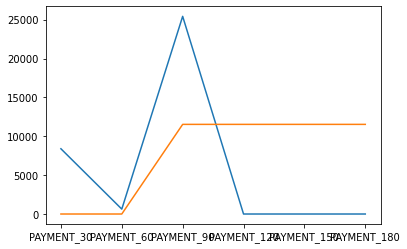

In [20]:
df.loc[2085231][payment_heads].plot()
df.loc[2553780][payment_heads].plot()

In [21]:
df["PAYMENT_MEAN"] = df[payment_heads].mean(axis=1)
df["PAYMENT_STD"] = df[payment_heads].std(axis=1)

In [22]:
for head in payment_heads:
    df[head] = (df[head]-df["PAYMENT_MEAN"])/df["PAYMENT_STD"]

<AxesSubplot:>

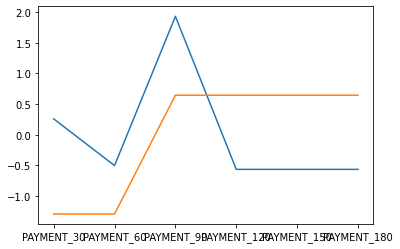

In [23]:
df.loc[2085231][payment_heads].plot()
df.loc[2553780][payment_heads].plot()

In [24]:
# Normalisierung AMT_DIFF

In [25]:
diff_heads = [head for head in df.columns.values if "AMT_DIFF" in head]

In [26]:
df["DIFF_MEAN"] = df[diff_heads].mean(axis=1)
df["DIFF_STD"] = df[diff_heads].std(axis=1)

In [27]:
for head in diff_heads:
    df[head] = (df[head]-df["DIFF_MEAN"])/df["DIFF_STD"]

In [28]:
df = df.drop(["PAYMENT_MEAN", "PAYMENT_STD", "DIFF_MEAN", "DIFF_STD"], axis=1)

In [29]:
df = df.fillna(0)

### Ergebnis

In [30]:
df = df.add_prefix("IP_")

In [31]:
df.head()

,IP_PAYMENT_30,IP_DAYS_DIFF_30,IP_AMT_DIFF_30,IP_PAYMENT_60,IP_DAYS_DIFF_60,IP_AMT_DIFF_60,IP_PAYMENT_90,IP_DAYS_DIFF_90,IP_AMT_DIFF_90,IP_PAYMENT_120,IP_DAYS_DIFF_120,IP_AMT_DIFF_120,IP_PAYMENT_150,IP_DAYS_DIFF_150,IP_AMT_DIFF_150,IP_PAYMENT_180,IP_DAYS_DIFF_180,IP_AMT_DIFF_180
SK_ID_PREV,,,,,,,,,,,,,,,,,,
2085231,0.260144,-7.0,0.0,-0.501375,23.0,0.0,1.931083,0.0,0.0,-0.563284,0.0,0.0,-0.563284,0.0,0.0,-0.563284,0.0,0.0
2260765,-0.912871,0.0,0.0,-0.912871,-3.0,0.0,-0.912871,-2.0,0.0,-0.912871,0.0,0.0,-0.912871,0.0,0.0,-0.912871,-1.0,0.0
1184783,-2.041241,0.0,0.0,0.408248,0.0,0.0,0.408248,0.0,0.0,0.408248,0.0,0.0,0.408248,0.0,0.0,0.408248,0.0,0.0
1003606,0.912871,0.0,0.0,0.912871,0.0,0.0,0.912871,0.0,0.0,0.912871,0.0,0.0,0.912871,0.0,0.0,0.912871,0.0,0.0
2553780,-1.290994,0.0,0.0,-1.290994,0.0,0.0,0.645418,-11.0,0.0,0.645524,-11.0,0.0,0.645524,-12.0,0.0,0.645524,-28.0,0.0


### Speichern der Werte

In [32]:
df.to_csv(DATASET_DIR / "2. Datenaufbereitung" / "ip.csv")

In [33]:
df.loc[1682318]

IP_PAYMENT_30       -0.935387
IP_DAYS_DIFF_30      0.000000
IP_AMT_DIFF_30       0.000000
IP_PAYMENT_60        1.802371
IP_DAYS_DIFF_60     -2.000000
IP_AMT_DIFF_60       0.000000
IP_PAYMENT_90        0.022801
IP_DAYS_DIFF_90     -2.000000
IP_AMT_DIFF_90       0.000000
IP_PAYMENT_120       0.022801
IP_DAYS_DIFF_120   -24.000000
IP_AMT_DIFF_120      0.000000
IP_PAYMENT_150       0.022801
IP_DAYS_DIFF_150    -2.000000
IP_AMT_DIFF_150      0.000000
IP_PAYMENT_180      -0.935387
IP_DAYS_DIFF_180     0.000000
IP_AMT_DIFF_180      0.000000
Name: 1682318, dtype: float64